In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import warnings
warnings.filterwarnings('ignore')
import re
from matplotlib.backends.backend_pdf import PdfPages

## This notebook studies the relationship between frequency and moral relevance for conceptual categories

In [2]:
# Loading COHA time-series data
ts_df = pd.read_csv('./data/SWOW_prediction/eval/time_series/ts_df.csv')

ts_df = ts_df.groupby(['words','year','property'])[['outputs_z','count']].mean().reset_index()
ts_df = ts_df.loc[ts_df['count'] >= 50]


In [3]:
#Loading category norm dataset
category_norms = pd.read_csv('./data/Referential version_Item level data.csv')
category_norms = category_norms.loc[category_norms['prod.freq'] > 1]
category_norms.groupby('category')['category.member'].count().to_dict()


{'academic subject': 41,
 'alcoholic drink': 30,
 'animal': 69,
 'art form': 16,
 'artistic movement': 9,
 'bathroom fixture': 19,
 'bird': 38,
 'bird of prey': 8,
 'boat': 16,
 'body of water': 15,
 'book genre': 22,
 'breed of dog': 36,
 'building': 34,
 'building material': 18,
 'camping equipment': 25,
 "carpenter's tool": 16,
 'chemical element': 35,
 'citrus fruit': 11,
 'clothing': 47,
 'colour': 24,
 'cosmetic': 23,
 'crime': 25,
 'dairy product': 11,
 'day of the week': 7,
 'disease': 24,
 'drug': 24,
 'emotion': 27,
 'fabric': 15,
 'family relationship': 42,
 'farm animal': 18,
 'fish': 26,
 'flower': 18,
 'four-legged animal': 38,
 'four-wheeled vehicle': 13,
 'fraction': 24,
 'fruit': 40,
 'fuel': 14,
 'furniture': 24,
 'gardening tool': 18,
 'gemstone': 12,
 'geometric shape': 17,
 'green vegetable': 19,
 'hair colour': 18,
 'hat': 17,
 'healthcare profession': 23,
 'herb': 16,
 'human dwelling': 18,
 'infectious disease': 14,
 'injury': 20,
 'insect': 27,
 'jewellery': 14

In [4]:
all_words = set(category_norms['category.member'])
ts_df = ts_df.loc[ts_df.words.isin(all_words)]
norms = category_norms.groupby('category')['category.member'].apply(list).to_dict()
print(len(norms))

117


In [5]:
category_df = pd.DataFrame()
for category in norms:
    words = norms[category]
    c_df = ts_df.loc[ts_df.words.isin(words)]
    c_df['category'] = category
    category_df = pd.concat((category_df, c_df), ignore_index = True)
    
    
rel_df = category_df.loc[category_df.property == 'previous_link']
pol_df = category_df.loc[category_df.property == 'polarity']

In [6]:
def get_growth_rate_word(category):
    c_df = rel_df.loc[rel_df.category == category]
    words = c_df.words.unique()
    if len(c_df) == 0:
        return []
    list_rows = []
    for word in words:
        w_df = c_df.loc[c_df.words == word]
        aggregate_moral_relevance = w_df.outputs_z.mean()
        is_moral = aggregate_moral_relevance > 0
                
        min_year = w_df.year.min()
        w_df['year'] = (w_df['year'] - min_year + 1) / 10
        model = smf.ols('outputs_z ~ year', data = w_df).fit() 
        list_rows.append( {'category':category,
                           'word':word,
               'r2': model.rsquared,
               'n':len(w_df),
               'fpvalue':model.f_pvalue,
                'intercept_coef': model.params.Intercept,
               'year_pvalue':model.pvalues.year,
               'year_coef':model.params.year,
               'is_moral':is_moral,
               'moral_relevance':aggregate_moral_relevance})
    result = pd.DataFrame(list_rows)
    return result
    
        
    
def get_growth_rate(category):
    c_df = rel_df.loc[rel_df.category == category]
    last_year_moral_relevance = c_df.loc[c_df.year == 2000].outputs_z.mean()
    if len(c_df) == 0:
        return []
    c_df = c_df.groupby('year')['outputs_z'].mean().reset_index()
    is_moral = True
    aggregate_moral_relevance = c_df.outputs_z.mean()
    if aggregate_moral_relevance < 0:
        is_moral = False
    min_year = c_df.year.min()
    c_df['year'] = (c_df['year'] - min_year + 1) / 10
    model = smf.ols('outputs_z ~ year', data = c_df).fit() 
    return {'category':category,
           'r2': model.rsquared,
           'n':len(c_df),
           'fpvalue':model.f_pvalue,
            'intercept_coef': model.params.Intercept,
           'year_pvalue':model.pvalues.year,
           'year_coef':model.params.year,
           'is_moral':is_moral,
           'moral_relevance':aggregate_moral_relevance,
           'final_moral_relevance':last_year_moral_relevance }
    
def plot_reg(category):
    c_df = rel_df.loc[rel_df.category == category]
    c_df = c_df.groupby('year')[['outputs_z','count_log']].mean().reset_index()
    min_year = c_df.year.min()
    c_df['log_year'] = (c_df['year'] - min_year + 1)
    model = smf.ols('outputs_z ~ log_year', data = c_df).fit() 
    r2, coef = model.rsquared,model.params.log_year
    fig, axes = plt.subplots(1, 2, figsize = (10, 3))
    ax = axes[0]
    sns.regplot(data = c_df, x = 'year', y = 'outputs_z',ax =ax)
    ax.set_xlabel('year')
    ax.set_ylabel('Average moral relevance')
    ax.set_title(category.capitalize() + f' | R2: {round(r2,3)}')
    ax = axes[1]
    model = smf.ols('count_log ~ log_year', data = c_df).fit() 
    r2, coef = model.rsquared,model.params.log_year
    sns.regplot(data = c_df, x = 'year', y = 'count_log',ax =ax)
    ax.set_xlabel('year')
    ax.set_ylabel('Average log frequency')

    ax.set_title(category.capitalize() + f' | R2: {round(r2,3)}')
    sns.despine()
    plt.savefig(f'notebooks/figs/{category}_relevance_freq.pdf',dpi = 400, bbox_inches='tight')
    plt.show()

        
    
    
    

In [7]:
rel_df['count_log'] = np.log(rel_df['count'])
pol_df['count_log'] = np.log(pol_df['count'])



In [8]:
category = 'supernatural being'
c_df = rel_df.loc[rel_df.category == category]

### As shown below, the frequency of category norms in COHA corpus is not a good predictor of its moral relevance.

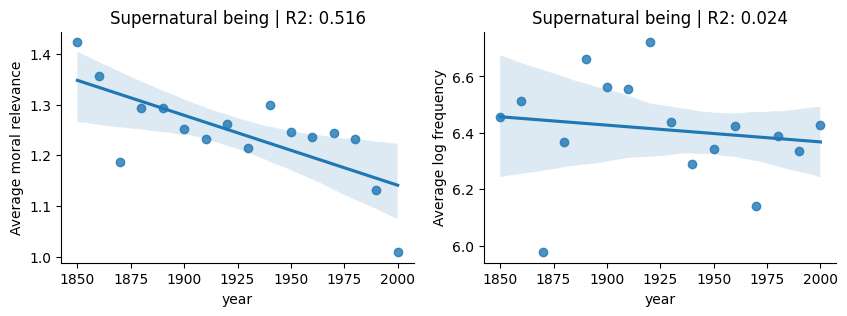

In [9]:
plot_reg(category)

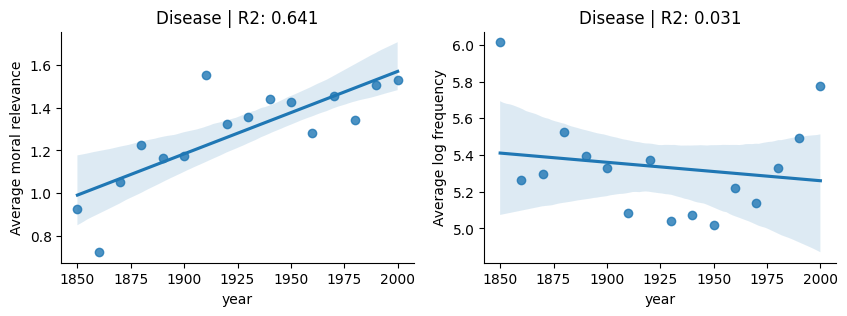

In [10]:
plot_reg('disease')

In [12]:
## Moral relevance and frequency are only weakly correlated
pearsonr(rel_df[['outputs_z','count_log']].drop_duplicates().values.T[0],
         rel_df[['outputs_z','count_log']].drop_duplicates().values.T[1])


PearsonRResult(statistic=0.08370939233553681, pvalue=3.24582383684995e-24)

In [14]:
## Same result using all the COHA corpus
ts_df_rel = ts_df.loc[ts_df.property == 'previous_link']
pearsonr(ts_df_rel[['outputs_z','count']].drop_duplicates().values.T[0],
            ts_df_rel[['outputs_z','count']].drop_duplicates().values.T[1])

PearsonRResult(statistic=0.04423106642327208, pvalue=8.442196023770646e-08)